## Testing model

In [1]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot") # 這行程式碼設置了 matplotlib 的繪圖風格。

# 這是 Jupyter Notebook 的魔法命令，它用於指定 matplotlib 繪圖的輸出方式。
# 可以直接在 Notebook 中看到圖形，而不需要使用 plt.show()。
%matplotlib inline 
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras import backend as K

from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras.preprocessing.image import *
from keras.callbacks import *

from keras.utils import plot_model

import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Get Data

In [2]:
class DataGen(keras.utils.Sequence):
    def __init__(self, path, ids, batch_size=8, image_size=640):
        self.path = path
        self.ids = ids
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    # 回傳 steps_per_epoch , 也就是一個 epoch 需要幾個 batch 
    def __len__(self): 
        return int(np.ceil(len(self.ids) / self.batch_size))
        
    def __load__(self, id_name):
        image_path = os.path.join(self.path, "Images", id_name)
        mask_path = os.path.join(self.path, "Mask", id_name)

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask, axis=-1)

        # Normalizaing 
        image = image / 255.0
        mask = mask / 255.0

        return image, mask

    # 獲取當次 batch 要訓練的照片
    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.ids):
            ids_batch = self.ids[index * self.batch_size : len(self.ids)]
        else:
            ids_batch = self.ids[index * self.batch_size : (index+1) * self.batch_size]
        
        images = []
        masks = []
        
        for id_name in ids_batch:
            _img, _mask = self.__load__(id_name)
            images.append(_img)
            masks.append(_mask)
        
        images = np.array(images)
        masks = np.array(masks)

        return images, masks
    
    def get_id(self, i):
        return self.ids[i]
    
    def on_epoch_end(self):
        pass

3 ['2_jpg.rf.60369561fc1520a37e9145f6ecd47916.jpg', '4_jpg.rf.38e454f25bf0b15ff1cf507920b872bd.jpg', '8_jpg.rf.b0df4a218edbe5fb7e0e023f2428d25f.jpg']
1 ['11_jpg.rf.2e71343ba8845ca7db0b208ae1a6b064.jpg']
(1, 640, 640, 1) (1, 640, 640, 1)
(1, 640, 640, 1) (1, 640, 640, 1)


15

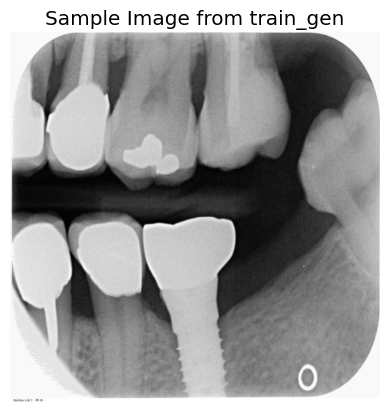

In [3]:
# 參數設定
train_path = "dataset_copy_3_imgs/train/"
train_ids = os.listdir(train_path + "Images") # list
valid_path = "dataset_copy_3_imgs/valid/"
valid_ids = os.listdir(valid_path + "Images") # list
batch_size = 1
image_size = 640

# 建立 DataGen 物件
train_gen = DataGen(train_path, train_ids, batch_size, image_size)
valid_gen = DataGen(valid_path, valid_ids, batch_size, image_size)

# 使用 DataGen 類別的 __len__ 函式
print(train_gen.__len__(), train_ids)
print(valid_gen.__len__(), valid_ids)

# 使用 DataGen 類別的 __getitem__ 函式
x, y = train_gen.__getitem__(0)
print(x.shape, y.shape)
x, y = train_gen.__getitem__(1)
print(x.shape, y.shape)

# 從 batch 中選擇其中一張圖片
image_to_display = x[0]

# 將圖片轉換為 0 到 255 的範圍
image_to_display = (image_to_display * 255).astype(np.uint8)

# 顯示圖片
plt.imshow(image_to_display[:, :, 0], cmap='gray')  # 若是彩色圖片，請將 [:, :, 0] 移除
plt.title('Sample Image from train_gen')
plt.axis('off')

gc.collect() #  用於清理不再使用的對象，釋放內存。（Garbage Collection）

## Set model

In [5]:
def DenseBlock(channels,inputs):

    conv1_1 = Conv2D(channels, (1, 1),activation=None, padding='same')(inputs)
    conv1_1 = BatchActivate(conv1_1)
    conv1_2 = Conv2D(channels//4, (3, 3), activation=None, padding='same')(conv1_1)
    conv1_2 = BatchActivate(conv1_2)

    conv2=concatenate([inputs,conv1_2])
    conv2_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv2)
    conv2_1 = BatchActivate(conv2_1)
    conv2_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv2_1)
    conv2_2 = BatchActivate(conv2_2)

    conv3 = concatenate([inputs, conv1_2,conv2_2])
    conv3_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv3)
    conv3_1 = BatchActivate(conv3_1)
    conv3_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv3_1)
    conv3_2 = BatchActivate(conv3_2)

    conv4 = concatenate([inputs, conv1_2, conv2_2,conv3_2])
    conv4_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv4)
    conv4_1 = BatchActivate(conv4_1)
    conv4_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv4_1)
    conv4_2 = BatchActivate(conv4_2)
    result=concatenate([inputs,conv1_2, conv2_2,conv3_2,conv4_2])
    return result

def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


def DenseUNet(image_size=304):

    filters=16
    keep_prob=0.9
    block_size=7

    inputs = Input(shape=(image_size, image_size, 1)) # change 

    conv1 = Conv2D(filters * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchActivate(conv1)
    conv1 = DenseBlock(filters * 1, conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = DenseBlock(filters * 2, pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = DenseBlock(filters * 4, pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)

    convm = DenseBlock(filters * 8, pool3)

    deconv3 = Conv2DTranspose(filters * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Conv2D(filters * 4, (1, 1), activation=None, padding="same")(uconv3)
    uconv3 = BatchActivate(uconv3)
    uconv3 = DenseBlock(filters * 4, uconv3)


    deconv2 = Conv2DTranspose(filters * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(filters * 2, (1, 1), activation=None, padding="same")(uconv2)
    uconv2 = BatchActivate(uconv2)
    uconv2 = DenseBlock(filters * 2, uconv2)

    deconv1 = Conv2DTranspose(filters * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(filters * 1, (1, 1), activation=None, padding="same")(uconv1)
    uconv1 = BatchActivate(uconv1)
    uconv1 = DenseBlock(filters * 1, uconv1)

    outputs = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    outputs = Activation('sigmoid')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [9]:
model = DenseUNet(image_size=640) # change 

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 640, 640, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 640, 640, 16)         160       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 640, 640, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 640, 640, 16)         0         ['batch_normalization[0][0

In [11]:
model.load_weights('model/model-DenseUnet.h5')

## Predict Images

In [13]:
## Dataset for prediction
test_path = "dataset_copy_3_imgs/valid/"
test_ids = os.listdir(test_path + "Images")
test_gen = DataGen(test_path, test_ids, image_size=image_size, batch_size=batch_size)

# 先預測 2 batch 的照片
x_image, y_mask, result_list, image_name = [], [], [], []
for i in range(5):
    x, y = test_gen.__getitem__(i)
    x_image.append(x)
    y_mask.append(y)
    result = model.predict(x)
    result_list.append(result)
    image_name.append(test_gen.get_id(i))


AbortedError: Graph execution error:

Detected at node model/conv2d_transpose_1/conv2d_transpose defined at (most recent call last):
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\runpy.py", line 197, in _run_module_as_main

  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\runpy.py", line 87, in _run_code

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\asyncio\base_events.py", line 601, in run_forever

  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\asyncio\base_events.py", line 1905, in _run_once

  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\asyncio\events.py", line 80, in _run

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\ipykernel\kernelbase.py", line 529, in dispatch_queue

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\ipykernel\kernelbase.py", line 518, in process_one

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\ipykernel\kernelbase.py", line 424, in dispatch_shell

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\ipykernel\kernelbase.py", line 766, in execute_request

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code

  File "C:\Users\user\AppData\Local\Temp\ipykernel_3644\422988625.py", line 12, in <module>

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 2655, in predict

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\layers\convolutional\conv2d_transpose.py", line 296, in call

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\backend.py", line 6268, in conv2d_transpose

Operation received an exception:Status: 1, message: could not create a primitive, in file tensorflow/core/kernels/mkl/mkl_conv_grad_input_ops.cc:545
	 [[{{node model/conv2d_transpose_1/conv2d_transpose}}]] [Op:__inference_predict_function_6092]

In [9]:
print(image_name)

['101_jpg.rf.4c511af7a1c76cbaf95c464a520cf88a.jpg', '103_jpg.rf.a37da8d11fb8a2c7330f64f64ce59e1e.jpg', '109_jpg.rf.d1572b8ca404851ee30b60871180073f.jpg', '114_jpg.rf.48671828485d2f4819c15905f3a42f92.jpg', '121_jpg.rf.d38fc94b258d67991fba10115cee43fe.jpg']


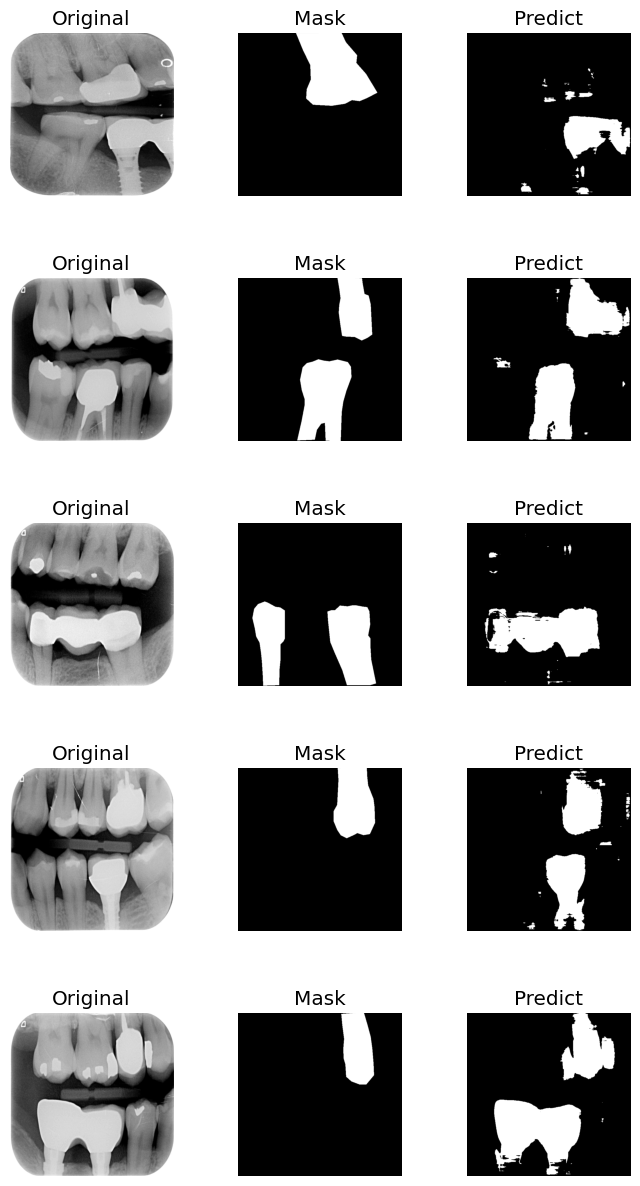

In [14]:
# 建立圖表物件(Figure object)，hsapce 、 wspace 垂直間距，水平間距
fig = plt.figure(figsize=(8, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# print(result.shape) # (1, 640, 640, 1)


for i in range(5):
    # AxesSubplot 代表子圖（subplot）的物件。
    ax = fig.add_subplot(5, 3, 3*i + 1)
    ax.set_title("Original")
    ax.imshow(x_image[i][0]*255, cmap="gray")
    ax.set_axis_off()

    ax = fig.add_subplot(5, 3, 3*i + 2)
    ax.set_title("Mask")
    ax.imshow(y_mask[i][0]*255, cmap="gray")
    ax.set_axis_off()

    res = result_list[i][0] > 0.5
    ax = fig.add_subplot(5, 3, 3*i + 3)
    ax.set_title("Predict")
    ax.imshow(res*255, cmap="gray") # 要把第一個 batch 忽略，所以 [0]
    ax.set_axis_off()

## Save predict images

In [11]:
# 影像數據通常是一個 NumPy 陣列，且數據類型應為 np.uint8。
for i in range(len(result_list)):
    path = "result/predict_images/" + image_name[i] + ".jpg"
    image = (result_list[i][0] * 255).astype(np.uint8)
    cv2.imwrite(path, image)